# Lab 3: Message authentication and Integrity protection
Laboratory session 3 of *Information Security*, AY 2024/25. In this notebook, we implement an authentication scheme and evaluate its weakness through a substitution and a forging attack.


In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import random
import time

## Task 1: Authentication scheme
Consider the following symmetric scheme for message authentication and integrity protection:
- the message $u$ is a sequence of $M$ bits
- the key $k$ is a sequence of $K$ bits
- the authentication tag $t$ is the binary representation of the integer product $s = s_u s_k$, where $s_u$ and
$s_k$ are the sum of the digits in the decimal (base 10) representation of $u$ and $k$, respectively.

The tag is transmitted along with the message $u$, and the receiver, which knows $k$, computes the tag
from the received message and checks whether it is identical to the received tag. If so, the message is
accepted as authentic.
Using a programming language of your choice, implement the above scheme, and the corresponding
verification so that the complexity of each is polynomial in both $M$ and $K$.

In [2]:
def computeDigitSum(x: int):
    # computes sum of digits of a given integer x
    s = 0
    while x > 0:
        s += x % 10
        x //= 10
    return s
    
def computeTag(u, k):
    # computes authentication tag given 2 bit sequences: message u and key k
    s_u = computeDigitSum(int(u, 2))
    s_k = computeDigitSum(int(k, 2))
    #t = bin(s_u*s_k)[2:]
    t = f'{s_u*s_k:b}'
    return t 

def authScheme(u, k, verbose=False):
    t = computeTag(u, k) # compute tag
    x = u+t # append tag to message
    
    if verbose: # verbose output for debugging
        print(f"Message u: {u}")
        print(f"Key k: {k}")
        print(f"Tag t: {t}")
        print(f"Sending x: {x}")

    return x

# length M of message is known
def checkReceived(x, k, M, verbose=False):
    # checks authenticity based on tag of received bitstring x, 
    # knowing key k and length of message M
    
    # split received bitstring into message u and tag t
    u = x[:M] # message
    t = x[M:] # tag
    # compute real tag t from u and key k
    t_check = computeTag(u, k)
    accept = t == t_check
    
    if verbose: # verbose output for debugging
        print(f"received tag: {t}")
        print(f"computed tag: {t_check}")
        if accept:
            print("Message accepted!")
        else: ("Message rejected!")
            
    return accept

In [3]:
u = '00000001' # message
k = '1111111' # key
M = len(u) # known length of message bitstring
x = authScheme(u, k, verbose=True)
accept = checkReceived(x, k, M, verbose=True)

Message u: 00000001
Key k: 1111111
Tag t: 1010
Sending x: 000000011010
received tag: 1010
computed tag: 1010
Message accepted!


Test with random keys/messages:

In [4]:
# check if authentic messages are accepted correctly
accepted = 0
M = 8
K = 8
N= 10000
for _ in range(N):
    u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
    k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
    x = authScheme(u, k)
    accepted += checkReceived(x, k, M)
print(f"Correctly accepted: {accepted} of {N}")

# check acceptance rate of random messages
accepted = 0
for _ in range(N):
    x = "".join(str(random.randint(0, 1)) for i in range(M)) + f"{computeDigitSum(random.randint(0, 2**K-1)):b}" # fake message
    k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
    accepted += checkReceived(x, k, M)
print(f"Incorrectly accepted: {accepted} of {N}")

Correctly accepted: 10000 of 10000
Incorrectly accepted: 42 of 10000


### Average computation time vs message length $M$
In the following, we fix the key length $K=10$ and evaluate the average computation time of the authentication and verification of random message-key pairs for different message lengths $M$, averaging over 100 repetitions each.

In [5]:
# time the authentication and verification
K = 10 # fixed key length 
M_vals = np.logspace(1, 5, 50, dtype=int) # values of message length M to test
N = 100 # repetitions per M_val
avg_time_M = np.empty((len(M_vals), 3), dtype=float) # save average computation time for each M
std_time_M = np.empty((len(M_vals), 3), dtype=float) # save stddev of computation time for each M
for j, M in enumerate(M_vals):
    time_arr = np.empty((N, 3), dtype=float)
    for i in range(N):
        u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
        start = time.perf_counter_ns()
        x = authScheme(u, k) # authentication
        step1 = time.perf_counter_ns()
        accepted = checkReceived(x, k, M) # verification
        step2 = time.perf_counter_ns()
        time_arr[i, :] = [step1 - start, step2 - step1, step2 - start] # [auth_time, verify_time, tot_time]
    avg_time_M[j, :] = np.mean(time_arr, axis=0) # save avg time
    std_time_M[j, :] = np.std(time_arr, axis=0) # save time stddev

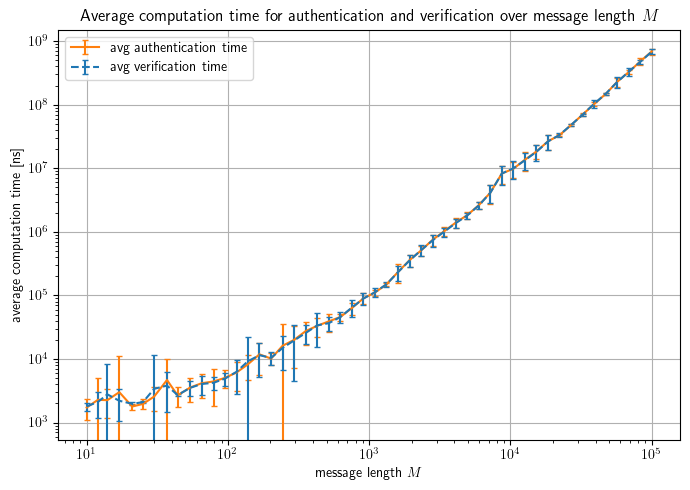

In [6]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(M_vals, avg_time_M[:, 0], yerr=std_time_M[:, 0], label="avg authentication time", capsize=2, c='tab:orange')
ax.errorbar(M_vals, avg_time_M[:, 1], yerr=std_time_M[:, 1], label="avg verification time", capsize=2, ls='--', c='tab:blue')
#ax.errorbar(M_vals, avg_time_M[:, 2], yerr=std_time_M[:, 2], label="total" )
ax.legend(loc='best')
ax.set_xlabel("message length $M$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for authentication and verification over message length $M$')
ax.grid()
fig.savefig("auth_scheme_time_vs_M", dpi=1000)
plt.show()

### Average computation time vs key length $K$
In the following, we fix the message lenght $M=10$ and evaluate the average computation time of the authentication and verification of random message-key pairs for different key lengths $K$, averaging over 100 repetitions each.

In [7]:
# time the authentication and verification
M = 10 # fixed message length 
K_vals = np.logspace(1, 5, 50, dtype=int) # values of key length K to test
N = 100 # repetitions per K_val
avg_time_K = np.empty((len(K_vals), 3), dtype=float) # save average computation time for each K
std_time_K = np.empty((len(K_vals), 3), dtype=float) # save stddev of computation time for each K
for j, K in enumerate(K_vals):
    time_arr = np.empty((N, 3), dtype=float)
    for i in range(N):
        u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
        start = time.perf_counter_ns()
        x = authScheme(u, k) # authentication
        step1 = time.perf_counter_ns()
        accepted = checkReceived(x, k, M) # verification
        step2 = time.perf_counter_ns()
        time_arr[i, :] = [step1 - start, step2 - step1, step2 - start] # [auth_time, verify_time, tot_time]
    avg_time_K[j, :] = np.mean(time_arr, axis=0) # save avg time
    std_time_K[j, :] = np.std(time_arr, axis=0) # save time stddev

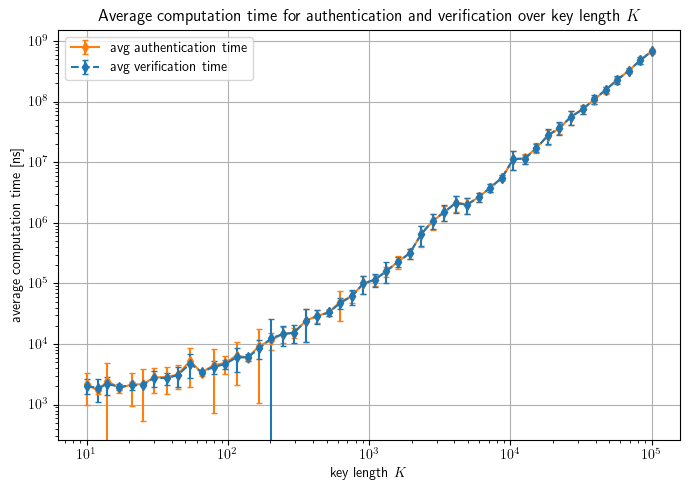

In [8]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(K_vals, avg_time_K[:, 0], yerr=std_time_K[:, 0], label="avg authentication time", capsize=2, marker="d", markersize=5, c="tab:orange")
ax.errorbar(K_vals, avg_time_K[:, 1], yerr=std_time_K[:, 1], label="avg verification time", capsize=2, marker="d", markersize=5, ls='--', c='tab:blue')
#ax.errorbar(K_vals, avg_time_K[:, 2], yerr=std_time_K[:, 2], label="total" )
ax.legend(loc='best')
ax.set_xlabel("key length $K$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for authentication and verification over key length $K$')
ax.grid()
fig.savefig("auth_scheme_time_vs_K", dpi=1000)
plt.show()

## Task 2: Substitution attack
Your aim is to evaluate the weakness of the naive symmetric scheme for message authentication and
integrity protection, implemented in Task 1.
- design and implement a substitution attack to the above scheme that, without knowing the key $k$,
and after blocking and observing a legitimate message/tag pair $x = (u, t)$ sent by A, replaces it
with a different pair $\tilde{x} = (\tilde{u}, \tilde{t})$ so that $\tilde{u}$ is accepted by B as authentic;
- evaluate the computational complexity for this attack.

What is the success probability of your attack strategy?

Kerchoff-like assumption: Since we as Forger know the tag map $T(u, k) = (s_u \cdot s_k)_2$, we can extract the tag from the blocked pair $(u, t)$ , compute $s_u$ and simply divide $t_{10}/s_u$ to compute the key digit sum $s_k$.

In [9]:
def maxDigitSum(x: int):
    # returns the maximum digit sum that an integer in the range [0, x] can have
    d = len(str(x))-1
    first_digit = x//10**d
    if x >= first_digit*10**d + sum(9*10**i for i in range(d)):
        return first_digit + d*9
    else: 
        return first_digit-1 + d*9 
        
def substitutionAttack(x, M, K, u_sub, verbose=False):
    # given intercepted output x (and known message length M, key length K)
    # computes a different output x_sub with the substituted message u_sub
    # and returns it
    # split x into message u and tag t
    u = x[:M]
    t = x[M:]

    # compute message digit sum s_u
    s_u = computeDigitSum(int(u, 2))
    # compute key digit sum from tag
    if s_u != 0:
        s_k = int(t, 2) // s_u
    else: # if s_u is 0 we can't get the key :(
        print("s_u = 0, can't determine key digit sum :(")
        print("guess random s_k")
        s_k = random.randint(0, maxDigitSum(2**int(K)-1)) # uniformly random guess

    # compute new tag for substitution message
    t_sub = f"{computeDigitSum(int(u_sub, 2))*s_k:b}"
    x_sub = u_sub + t_sub

    if verbose: # verbose output for debugging
        print(f"input pair x=({u}, {t})")
        print(f"key digit sum s_k: {s_k}")
        print(f"substituted pair x_sub=({u_sub}, {t_sub})")
        
    return x_sub    

In [10]:
# test with example
u = '00000001' # message
k = '1111111' # key
M = len(u) # known length of message bitstring
K = len(k)
x = authScheme(u, k, verbose=True) 
u_sub = '10000000'
x_sub = substitutionAttack(x, M, K, u_sub, verbose=True)
accept = checkReceived(x_sub, k, M, verbose=True)

Message u: 00000001
Key k: 1111111
Tag t: 1010
Sending x: 000000011010
input pair x=(00000001, 1010)
key digit sum s_k: 10
substituted pair x_sub=(10000000, 1101110)
received tag: 1101110
computed tag: 1101110
Message accepted!


In [11]:
# test with random message and key
accepted = 0
M = 8
K = 8
N = 1000
for _ in range(N):
    u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
    k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
    u_sub = "".join(str(random.randint(0, 1)) for i in range(M)) # substitution
    x = authScheme(u, k)
    x_sub = substitutionAttack(x, M, K, u_sub)
    accepted += checkReceived(x_sub, k, M)
print(f"Substitution accepted: {accepted} of {N}")

s_u = 0, can't determine key digit sum :(
s_u = 0, can't determine key digit sum :(
Substitution accepted: 998 of 1000


The attack succeeds as long as the blocked message isn't all 0 (such that $s_u=0$). 

### Average computation time vs message length $M$
In the following, we fix the key length $K=10$ and evaluate the average computation time of the substitution attack of random message, key and substitution bitstrings for different message lengths $M$, averaging over 100 repetitions each.

In [12]:
# time the substitution attack
K = 10 # fixed key length 
M_vals = np.logspace(1, 5, 50, dtype=int) # values of message length M to test
N = 100 # repetitions per M_val
avg_time_M = np.empty((len(M_vals), 3), dtype=float) # save average computation time for each M
std_time_M = np.empty((len(M_vals), 3), dtype=float) # save stddev of computation time for each M
for j, M in enumerate(M_vals):
    time_arr = np.empty((N, 3), dtype=float)
    for i in range(N):
        u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
        u_sub = "".join(str(random.randint(0, 1)) for i in range(M)) # substitution
        x = authScheme(u, k) # authentication
        start = time.perf_counter_ns()
        x_sub = substitutionAttack(x, M, K, u_sub)
        stop1 = time.perf_counter_ns() # substitution attack
        accept = checkReceived(x_sub, k, M)
        stop2 = time.perf_counter_ns() # verification
        time_arr[i, :] = [stop1 - start, stop2 - stop1, stop2 - start] # [subst_time, verify_time, tot_time]
    avg_time_M[j, :] = np.mean(time_arr, axis=0) # save avg time
    std_time_M[j, :] = np.std(time_arr, axis=0) # save time stddev

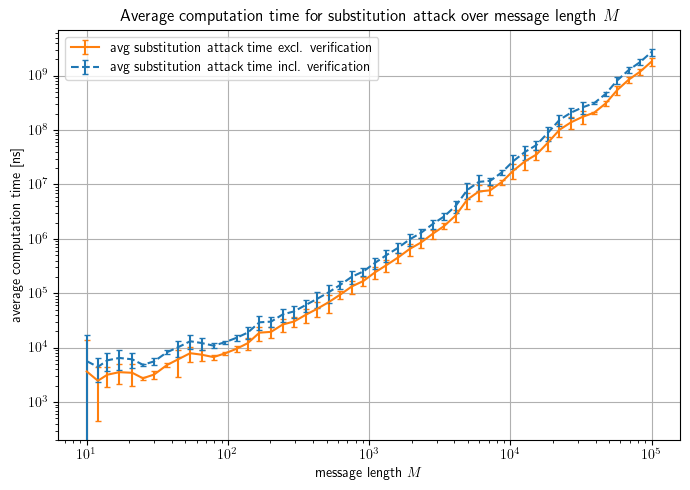

In [13]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(M_vals, avg_time_M[:, 0], yerr=std_time_M[:, 0], label="avg substitution attack time excl. verification", capsize=2, c='tab:orange')
#ax.errorbar(M_vals, avg_time_M[:, 1], yerr=std_time_M[:, 1], label="avg verification time", capsize=2, ls='--', c='tab:blue')
ax.errorbar(M_vals, avg_time_M[:, 2], yerr=std_time_M[:, 2], label="avg substitution attack time incl. verification", capsize=2, ls='--', c='tab:blue')
ax.legend(loc='best')
ax.set_xlabel("message length $M$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for substitution attack over message length $M$')
ax.grid()
fig.savefig("subst_attack_time_vs_M", dpi=1000)
plt.show()

### Average computation time vs key length $K$
In the following, we fix the message lenght $M=10$ and evaluate the average computation time of the substitution attack of random message, key and substitution bitstrings for different key lengths $K$, averaging over 100 repetitions each.

In [14]:
# time the substitution attack
M = 10 # fixed message length 
K_vals = np.logspace(1, 5, 50, dtype=int) # values of key length K to test
N = 100 # repetitions per K_val
avg_time_K = np.empty((len(K_vals), 3), dtype=float) # save average computation time for each K
std_time_K = np.empty((len(K_vals), 3), dtype=float) # save stddev of computation time for each K
for j, K in enumerate(K_vals):
    time_arr = np.empty((N, 3), dtype=float)
    for i in range(N):
        u = "".join(str(random.randint(0, 1)) for i in range(M)) # message
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key
        u_sub = "".join(str(random.randint(0, 1)) for i in range(M)) # substitution
        x = authScheme(u, k) # authentication
        start = time.perf_counter_ns()
        x_sub = substitutionAttack(x, M, K, u_sub)
        stop1 = time.perf_counter_ns() # substitution attack
        accept = checkReceived(x_sub, k, M)
        stop2 = time.perf_counter_ns() # verification
        time_arr[i, :] = [stop1 - start, stop2 - stop1, stop2 - start] # [subst_time, verify_time, tot_time]
    avg_time_K[j, :] = np.mean(time_arr, axis=0) # save avg time
    std_time_K[j, :] = np.std(time_arr, axis=0) # save time stddev

s_u = 0, can't determine key digit sum :(
s_u = 0, can't determine key digit sum :(
s_u = 0, can't determine key digit sum :(
s_u = 0, can't determine key digit sum :(
s_u = 0, can't determine key digit sum :(


KeyboardInterrupt: 

In [ ]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(K_vals, avg_time_K[:, 0], yerr=std_time_K[:, 0], label="avg substitution attack time excl. verification", capsize=2, c='tab:orange')
#ax.errorbar(K_vals, avg_time_K[:, 1], yerr=std_time_K[:, 1], label="avg verification time", capsize=2, ls='--', c='tab:blue')
ax.errorbar(K_vals, avg_time_K[:, 2], yerr=std_time_K[:, 2], label="avg substitution attack time incl. verification", capsize=2, ls='--', c='tab:blue')
ax.legend(loc='best')
ax.set_xlabel("key length $K$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for substitution attack over key length $K$')
ax.grid()
fig.savefig("subst_attack_time_vs_K", dpi=1000)
plt.show()

## Task 3: Forging attack
- design and implement a forging attack that, without knowing the key $k$, aims at creating a
message/tag pair $\tilde{x} = (\tilde{u}, \tilde{t})$ , such that $\tilde{u}$ is accepted by B as authentic;
- evaluate its computational complexity;
- evaluate its success probability.

In [ ]:
def forgingAttack(M, K, u_t, verbose=False):
    # attempts to forge a message-tag pair that is accepted as authentic
    # using target message u_t, knowing the message length M and key length K

    # compute corresponding digit sum
    s_u = computeDigitSum(int(u_t, 2))
    # maximum possible key digit sum
    max_sum = maxDigitSum(2**K-1)
    if verbose:
        print(f"max. possible key digit sum: {max_sum}")
    # brute force the possible key sums:
    for s_k in range(0, max_sum+1):
        t_f = f"{s_k*s_u:b}" # forged tag
        x_f = u_t + t_f # forged message-tag pair
        # stop if forged message is accepted
        accept = checkReceived(x_f, k, M)
        if accept:
            if verbose: 
                print("Forged message accepted!")
            break
            
    if verbose:
        print(f"key digit sum: {s_k}")
        print(f"forged pair: ({u_t}, {t_f})") 
        
    #return accept, s_k    

In [ ]:
# test example
M = 8 # message length
K = 8 # key length
k = "".join(str(random.randint(0, 1)) for i in range(K)) # key, unknown to forger
u_t = "".join(str(random.randint(0, 1)) for i in range(M)) # Forger's target message
forgingAttack(M, K, u_t, verbose=True)

### Average computation time vs message length $M$
In the following, we fix the key length $K=10$ and evaluate the average computation time of the forging attack of random message, key and substitution bitstrings for different message lengths $M$, averaging over 100 repetitions each.

In [ ]:
# time the forging attack
K = 10 # fixed key length 
M_vals = np.logspace(1, 5, 50, dtype=int) # values of message length M to test
N = 100 # repetitions per M_val
avg_time_M = np.empty(len(M_vals), dtype=float) # save average computation time for each M
std_time_M = np.empty(len(M_vals), dtype=float) # save stddev of computation time for each M
for j, M in enumerate(M_vals):
    time_arr = np.empty(N, dtype=float)
    for i in range(N):
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key, unknown to forger
        u_t = "".join(str(random.randint(0, 1)) for i in range(M)) # Forger's target message
        start = time.perf_counter_ns()
        forgingAttack(M, K, u_t) # forging attack
        stop = time.perf_counter_ns() 
        time_arr[i] = stop - start 
    avg_time_M[j] = np.mean(time_arr) # save avg time
    std_time_M[j] = np.std(time_arr) # save time stddev

In [ ]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(M_vals, avg_time_M, yerr=std_time_M, label="avg forging attack time", capsize=2)
ax.legend(loc='best')
ax.set_xlabel("message length $M$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for forging attack over message length $M$')
ax.grid()
fig.savefig("forg_attack_time_vs_M", dpi=1000)
plt.show()

### Average computation time vs key length $K$
In the following, we fix the message lenght $M=10$ and evaluate the average computation time of the forging attack of random message, key and substitution bitstrings for different key lengths $K$, averaging over 100 repetitions each.

In [ ]:
# time the forging attack
M = 10 # fixed message length 
K_vals = np.logspace(1, 5, 50, dtype=int) # values of key length K to test
N = 100 # repetitions per M_val
avg_time_K = np.empty(len(K_vals), dtype=float) # save average computation time for each M
std_time_K = np.empty(len(K_vals), dtype=float) # save stddev of computation time for each M
for j, K in enumerate(K_vals):
    time_arr = np.empty(N, dtype=float)
    for i in range(N):
        k = "".join(str(random.randint(0, 1)) for i in range(K)) # key, unknown to forger
        u_t = "".join(str(random.randint(0, 1)) for i in range(M)) # Forger's target message
        start = time.perf_counter_ns()
        forgingAttack(M, K, u_t) # forging attack
        stop = time.perf_counter_ns() 
        time_arr[i] = stop - start 
    avg_time_K[j] = np.mean(time_arr) # save avg time
    std_time_K[j] = np.std(time_arr) # save time stddev

In [ ]:
# make plot
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
ax.errorbar(K_vals, avg_time_K, yerr=std_time_K, label="avg forging attack time", capsize=2)
ax.legend(loc='best')
ax.set_xlabel("key length $K$")
ax.set_ylabel("average computation time [ns]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Average computation time for forging attack over key length $K$')
ax.grid()
fig.savefig("forg_attack_time_vs_K", dpi=1000)
plt.show()

### Success probability vs. message length $M$ and key length $K$
To Do!